# Undertanding the IMDB Reviews Data Set

Instructions
* You will need to make a new virtual enviroment so that the libraries we are going to use will work
    * Steps to create a virtual enviroment:
        * Go to the project directory and run this command:
            * python -m venv IMDB_ven
        * Then on MacOS, type this command:
            * source IMDB_ven/bin/activate
        * On Windows, type this command:
            * IMDB_ven\Scripts\activate
        * Now we are in the virtual enviroment
* Then download the libraries using the requirements.txt file, we will continue to add to this file if we need more libraries in our project
    * Run this command in your terminal to download the libraries:
        * pip install -r requirements.txt
* Now lets open the aclImdb_v1.tar.gz file
    * We can use the tar command to open up the file:
        * tar -xzvf aclImdb_v1.tar.gz
            * -x: Extracts the files
            * -z: Unzips the gzipped file
            * -v: Verbosely lists the files being extracted
            * -f: Specifies the file name
* Word of caution:
    * After unzipping the file please do not push the acllmdb file to the github repository since it is very large, that means typing 'git add .' will add this file to the github repository (by basically adding everything) so avoid using the '.'
    * Instead just add the files you would like to push by doing 'git add <name_of_file_you_want_to_push>'
    * Do not add the aclImdb_v1.tar.gz to github, just have this file in your local enviroment

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from wordcloud import WordCloud  

# these libraries are used for the text cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
# have a seperate helper function to load reviews from a folder
def load_reviews(folder_path, label):
    reviews = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            reviews.append(file.read())
    return pd.DataFrame({"review": reviews, "label": label})

In [3]:
# here we will store the base path to the dataset, then load the positive and negative reviews from the training data set to a dataframe
base_path = "aclImdb"

# since this is a classification problem, we will give pos reviews a 1 and neg reviews a 0
train_pos = load_reviews(os.path.join(base_path, "train/pos"), label=1)
train_neg = load_reviews(os.path.join(base_path, "train/neg"), label=0)

train_data = pd.concat([train_pos, train_neg]).reset_index(drop=True)

In [4]:
# show the data to get a rough idea of what we have
print("Number of reviews:", len(train_data))
display(train_data)

Number of reviews: 25000


,review,label
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1
...,...,...
24995,"My comments may be a bit of a spoiler, for wha...",0
24996,"The ""saucy"" misadventures of four au pairs who...",0
24997,"Oh, those Italians! Assuming that movies about...",0
24998,Eight academy nominations? It's beyond belief....,0


In [5]:
# we want to check the distribution of the data so that we can identify any imbalanced in the data
print("Label distribution:\n", train_data["label"].value_counts())

Label distribution:
 label
1    12500
0    12500
Name: count, dtype: int64


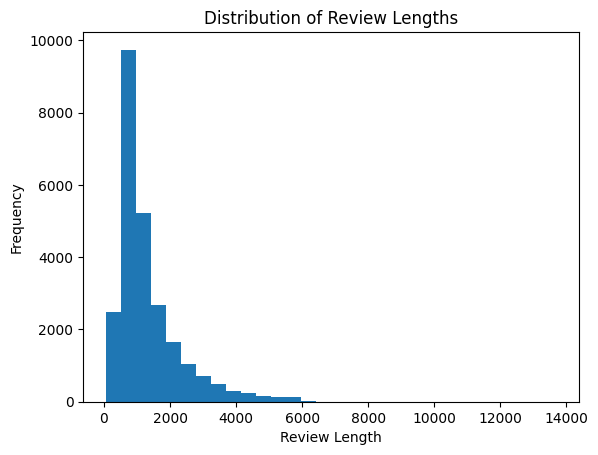

In [7]:
# looks like the data is evenly balanced, so now we want to see how long these reviews are
train_data["review_length"] = train_data["review"].apply(len) # creating a new column that stores the length of the data
plt.hist(train_data["review_length"], bins=30)
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

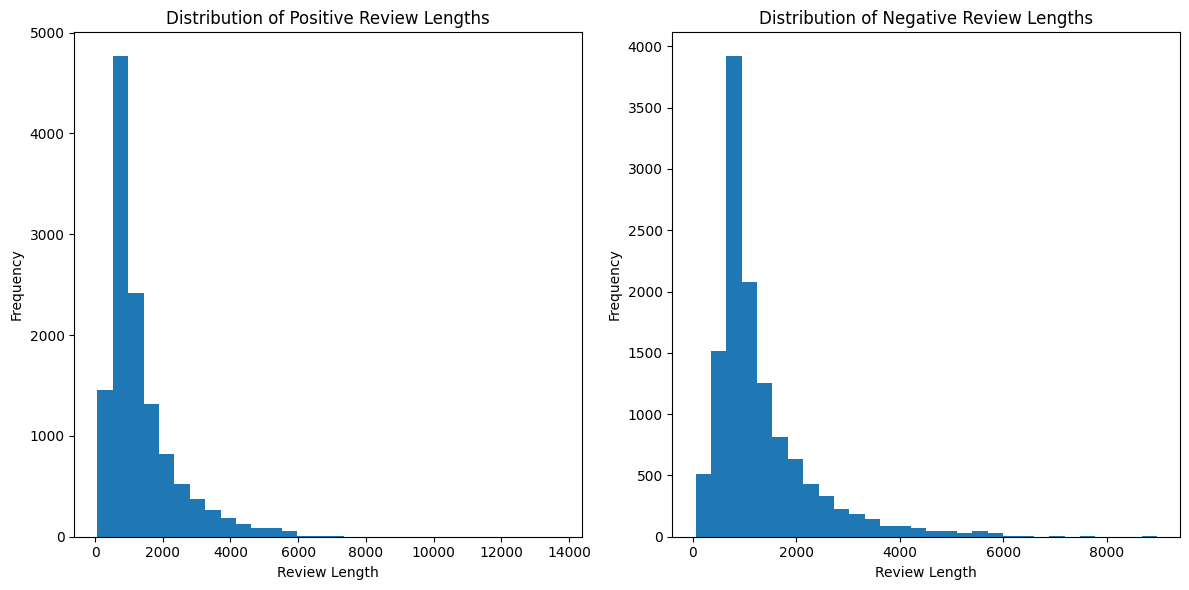

In [10]:
# we can try to see the length of reviews for both the negative and positive reviews as well
pos_reviews = train_data[train_data["label"] == 1]
neg_reviews = train_data[train_data["label"] == 0]

plt.figure(figsize=(12, 6))

# positive reviews
plt.subplot(1, 2, 1) # this graph will be stored in the first row first column
plt.hist(pos_reviews["review_length"], bins=30)
plt.title("Distribution of Positive Review Lengths")
plt.xlabel("Review Length")
plt.ylabel("Frequency")

# negative reviews
plt.subplot(1, 2, 2) # this graph will be stored in the first row second column
plt.hist(neg_reviews["review_length"], bins=30)
plt.title("Distribution of Negative Review Lengths")
plt.xlabel("Review Length")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [13]:
# it looks like the negative reviews have slightly longer reviews compared to the positive reviews, but at a galnce it does not look like much of a difference
# now I want to display the word frequency of the review data by using the word cloud, but first I will clean the text data and save it as a column to the data frame

# we need to run this bit of code for the cleaning to work, but you only need to run it once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/safiaboutaleb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/safiaboutaleb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/safiaboutaleb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# helper function clean text function to convert text to lowercase, remove special characters
# (punctuation, numbers, etc.), remove stop words, tokenize, and apply lemmatization

def clean_text(text):
  text = text.lower()

  text = re.sub(r'[^a-zA-Z\s]', '', text)

  tokens = word_tokenize(text)

  stop_words = set(stopwords.words("english"))
  tokens = [word for word in tokens if word not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  cleaned_text = ' '.join(tokens)

  return cleaned_text

In [16]:
train_data["cleaned_review"] = train_data["review"].apply(clean_text) # create a new column in our data frame that has the cleaned text so we can use it later
# we wont be using this cleaned text in the BERT model since it would perform poorly on pre cleaned data, so we will just use this for analysis and such

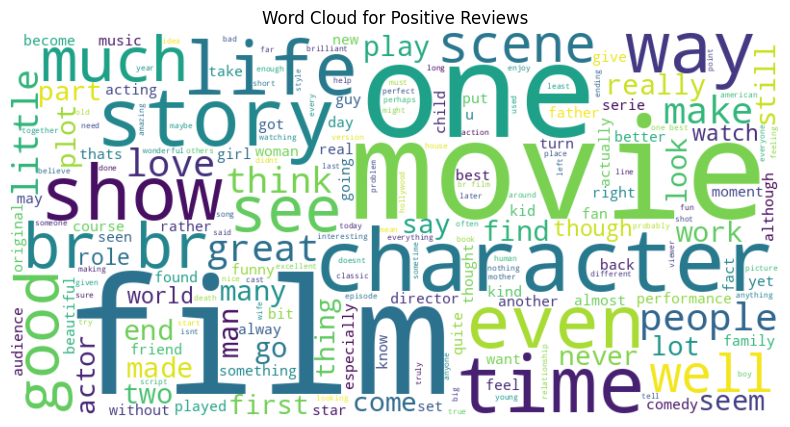

In [22]:
# lets take a look at the word cloud for the positive reviews then the neagtive reviews
pos_text = ' '.join(train_data[train_data["label"] == 1]["cleaned_review"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(pos_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")
plt.show()

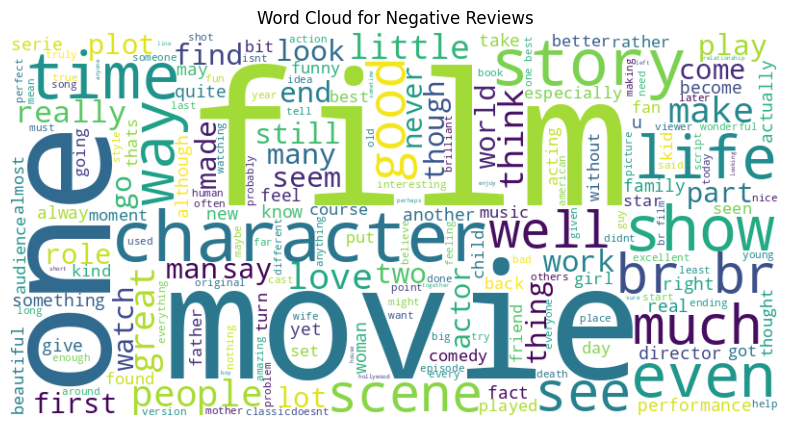

In [23]:
# then the negatvie reviews
neg_text = ' '.join(train_data[train_data["label"] == 0]["cleaned_review"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(pos_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Negative Reviews")
plt.show()

In [19]:
# take a look at the changes we made to the datafram again here
display(train_data)

,review,label,review_length,cleaned_review
0,For a movie that gets no respect there sure ar...,1,284,movie get respect sure lot memorable quote lis...
1,Bizarre horror movie filled with famous faces ...,1,1033,bizarre horror movie filled famous face stolen...
2,"A solid, if unremarkable film. Matthau, as Ein...",1,318,solid unremarkable film matthau einstein wonde...
3,It's a strange feeling to sit alone in a theat...,1,2596,strange feeling sit alone theater occupied par...
4,"You probably all already know this by now, but...",1,783,probably already know additional episode never...
...,...,...,...,...
24995,"My comments may be a bit of a spoiler, for wha...",0,978,comment may bit spoiler worth stop care enough...
24996,"The ""saucy"" misadventures of four au pairs who...",0,2473,saucy misadventure four au pair arrive london ...
24997,"Oh, those Italians! Assuming that movies about...",0,529,oh italian assuming movie aristocrat weird fet...
24998,Eight academy nominations? It's beyond belief....,0,2399,eight academy nomination beyond belief think b...
